## Reference - EDA + Baseline Model(0.40 RMSE)
https://www.kaggle.com/code/aiswaryaramachandran/eda-baseline-model-0-40-rmse

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
# pd.set_option('display.max_colwidth', -1)
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
# set_option 내부에 음수 값이 존재 하면 안된다 하여 오류남
# sklearn 신 버전에 대하여 Imputer 삭제된듯...?

In [7]:
# 데이터 셋 불러오기
train=pd.read_csv("week2_data/train.csv")
test=pd.read_csv("week2_data/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [6]:
# 데이터 배열상태 확인
train.shape

(1458644, 11)

In [0]:
# 데이터프레임 확인
train.head()

## EDA start

In [3]:
# 결측치 확인
test.isnull().sum()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


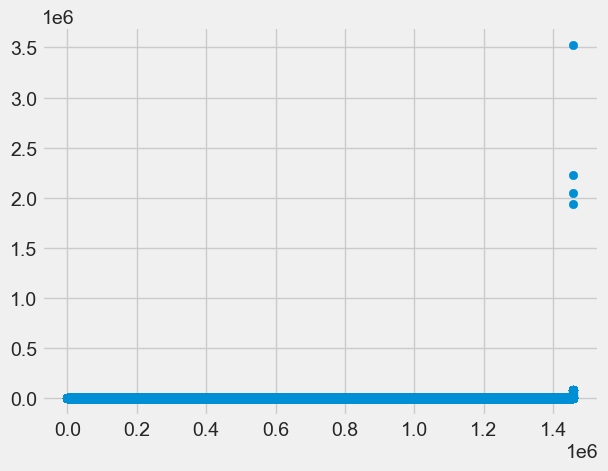

In [21]:
# 이상치 확인
# 산점도
plt.scatter(range(train.shape[0]), np.sort(train['trip_duration']))

In [11]:
# 전처리 - 날짜 자료형으로 변경 (기존은 object)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [12]:
# 최대, 최소 픽업시간 확인
print("Min pickup time:",min(train['pickup_datetime']))
print("Max pickup time:",max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


In [14]:
# 픽업 시간과 도착 시간 세분화
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

In [15]:
# 위경도 소수점 반올림
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x : round(x,3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x,3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x : round(x,3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x : round(x,3))

train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


In [40]:
# 이동거리 계산 함수 정의
# 하버사인 공식(Haversine Formula) 참고
def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance
    

In [22]:
# 이동거리 칼럼 정의
train['trip_distance']=train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [23]:
# 이동시간을 시속으로 표기
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x : x / 3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


Text(0.5, 0, 'Trip Duration (in hour)')

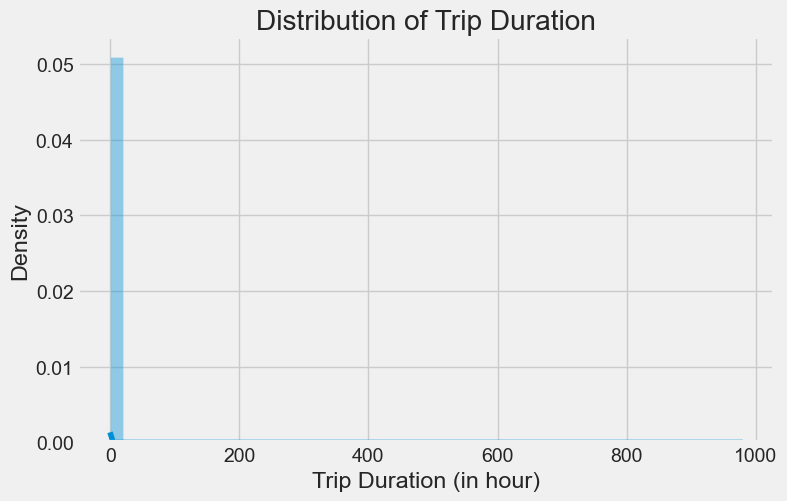

In [24]:
plt.figure(figsize = (8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

In [25]:
# 24시간 넘어가는 이상치 확인
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


In [26]:
# 이거 왜 두 번 쓰는지 모르갰음...
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

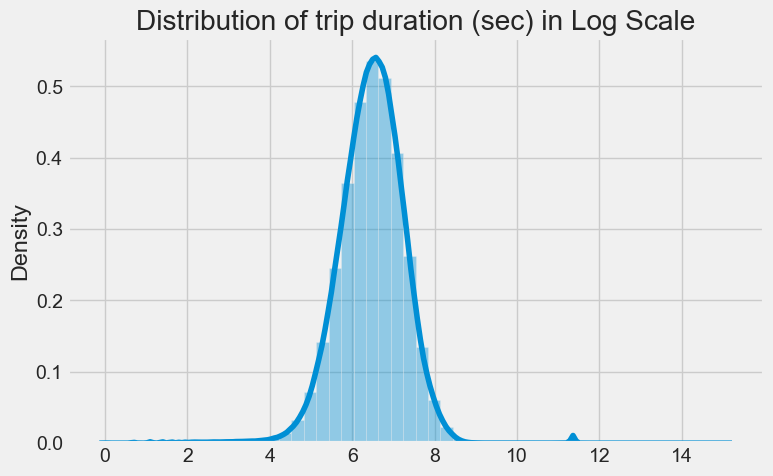

In [27]:
plt.figure(figsize = (8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

In [30]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns = {'id':'Num_Trips'})

In [39]:
# 실제 지도에 매핑 (Heatmap에서 value값을 쓰니 에러뜸. 제거 후 실행함)

pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in pickup.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        fill_color="#3db7e4", 
                        fill_opacity=0.9
                       ).add_to(pickup_map)
    count=count + 1


'''

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3, pickup.pickup_longitude_round3, pickup.Num_Trips)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

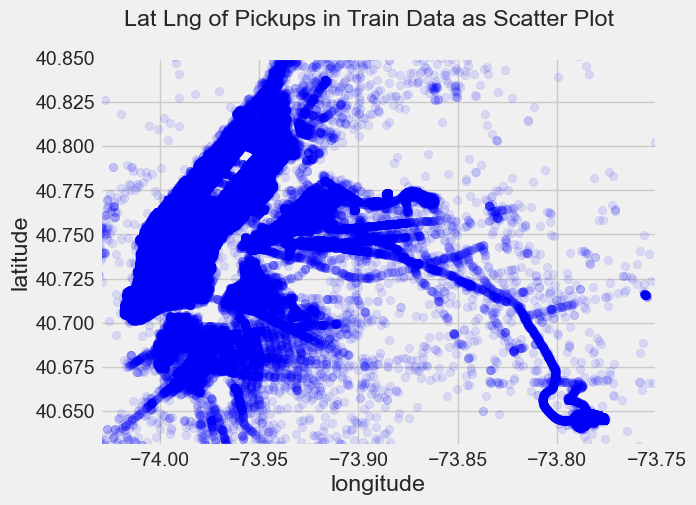

In [38]:
# 픽업장소에 대한 포화도 시각화
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              color='blue', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [41]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [43]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)
#print(pickup.shape)
### For each pickup point add a circlemarker
'''
for index, row in drop.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
    count=count + 1

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3, drop.dropoff_longitude_round3, drop.Num_Trips)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)




drop_map

In [44]:
pickup=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [45]:
# 왜 차이가 안 나타나지...
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3, pickup.pickup_longitude_round3, pickup.Avg_Trip_duration)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1 
                 )
pickup_map.add_child(hm_wide)
pickup_map

Text(0.5, 1.0, 'Pickup Hours Distribution')

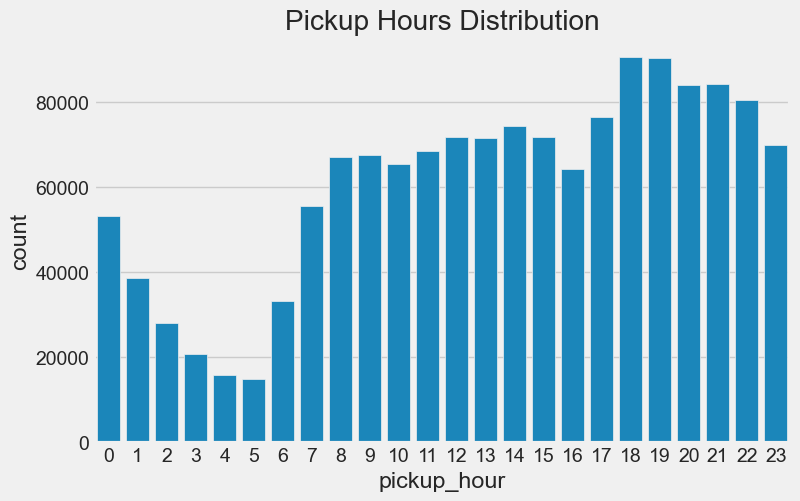

In [46]:
# 픽업 시간대 확인
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

Text(0.5, 1.0, 'Dropoff Hours Distribution')

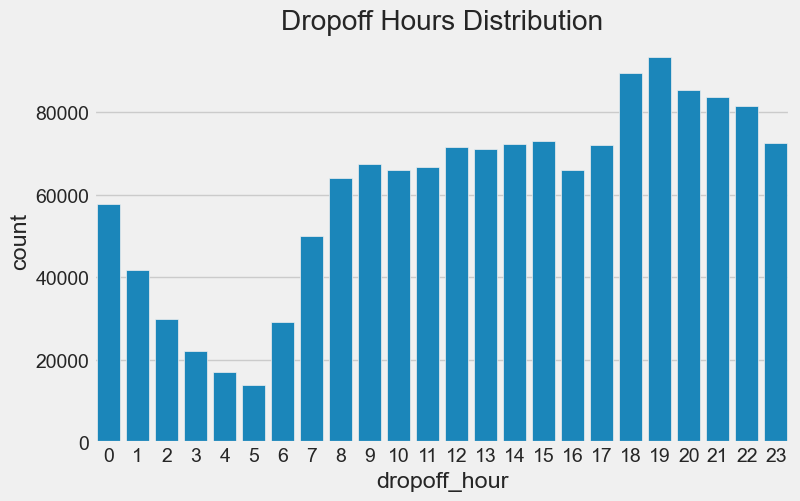

In [47]:
# 도착 시간대 확인
plt.figure(figsize = (8,5))
sns.countplot(x = train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Text(0.5, 1.0, 'Distribution of Pickups over time')

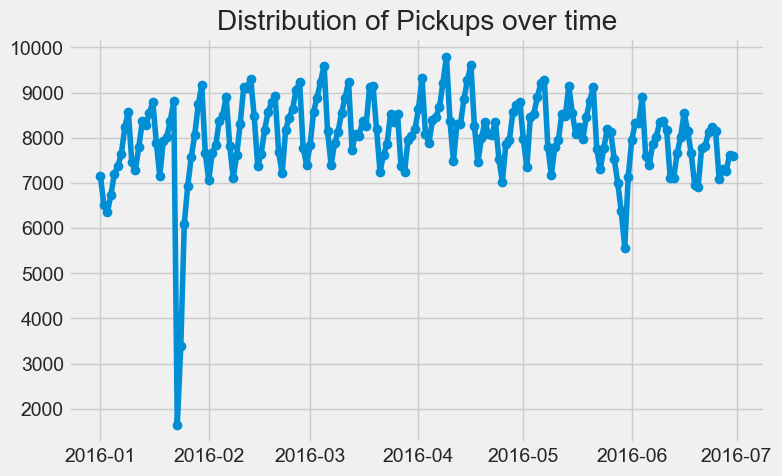

In [48]:
# 날짜별 픽업 수 확인
plt.figure(figsize = (8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')


plt.title("Distribution of Pickups over time")

Text(0.5, 0, 'Trip Distance (log)')

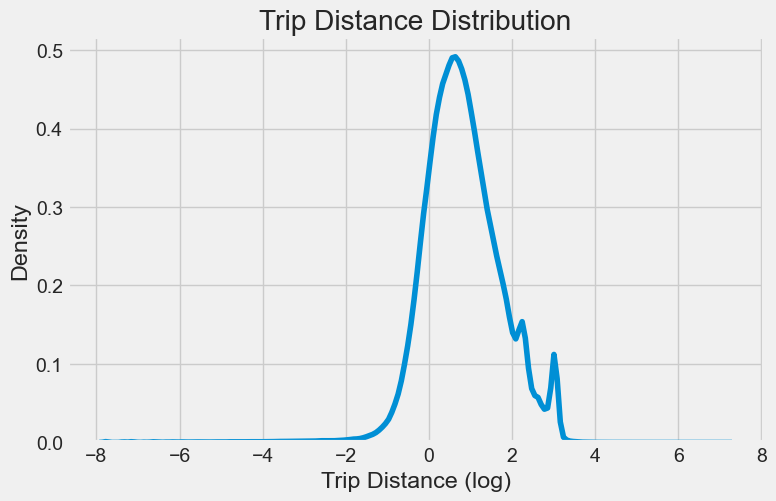

In [49]:
# 이동거리에 대한 로그스케일
plt.figure(figsize = (8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

Text(0, 0.5, 'Trip Duration (log scale)')

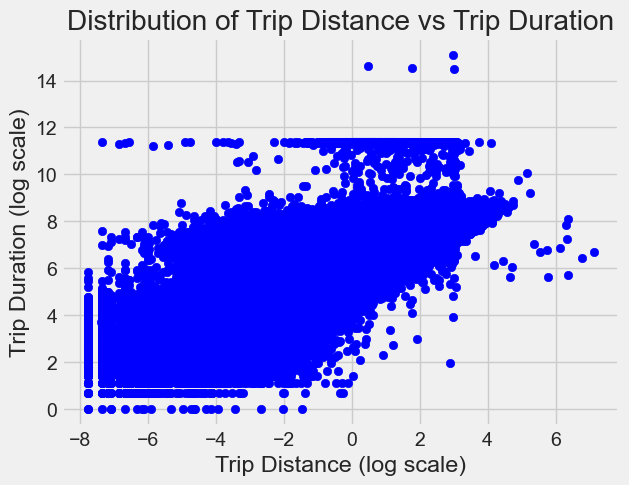

In [50]:
# 이동거리와 이동시간의 상관관계 확인
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
              color='blue', label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

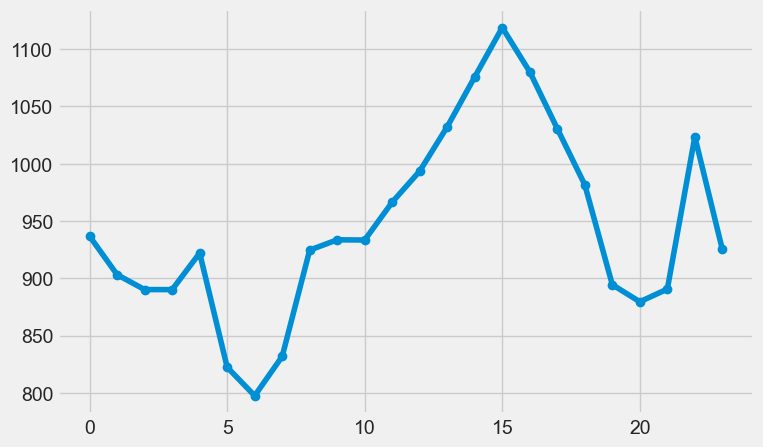

In [56]:
# 픽업 시간대별 평균 이동시간의 상관관계 (픽업시간으로 grouping)
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})
plt.figure(figsize = (8, 5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(),'o-')

<Axes: xlabel='count', ylabel='pickup_day_of_week'>

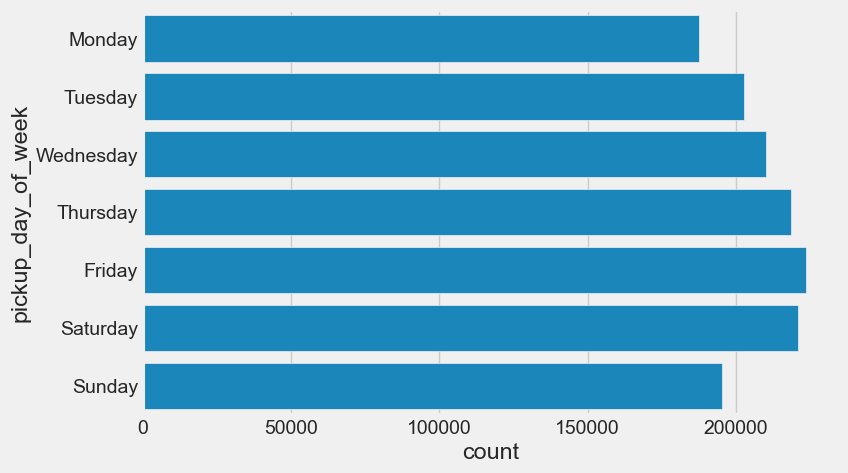

In [52]:
# 요일별 픽업수
plt.figure(figsize = (8,5))
sns.countplot(train['pickup_day_of_week'],order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

In [58]:
# 요일별 평균 이동시간의 상관관계
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

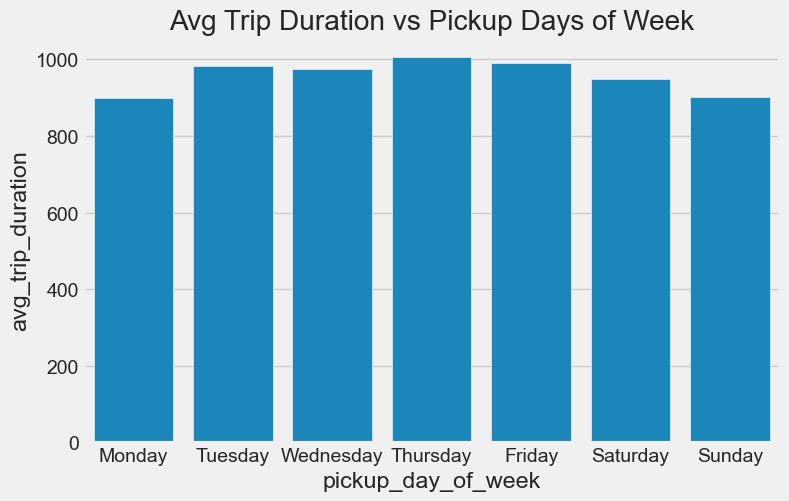

In [59]:
plt.figure(figsize = (8,5))
sns.barplot(x = 'pickup_day_of_week',y='avg_trip_duration',data = avg_duration_day, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Trip Duration vs Pickup Days of Week")

In [61]:
# Bearing Measure ???? 거리를 구하는 식인거같은데...
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [62]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)

<Axes: xlabel='bearing', ylabel='Density'>

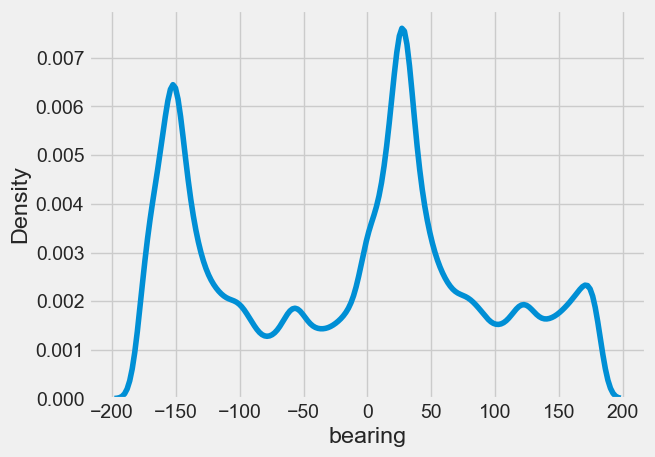

In [63]:
# Bearing으로 계산된 거리에 따른 밀도
sns.kdeplot(train['bearing'])

Text(0, 0.5, 'Trip Duration (log scale)')

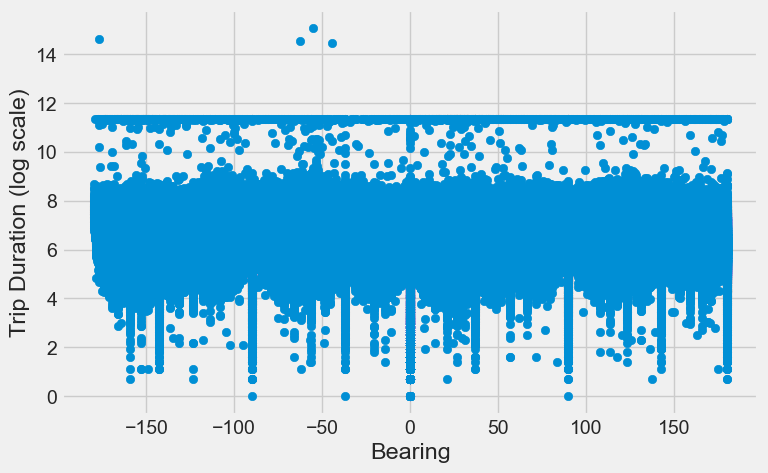

In [64]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

In [65]:
train['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

Text(0, 0.5, 'Density')

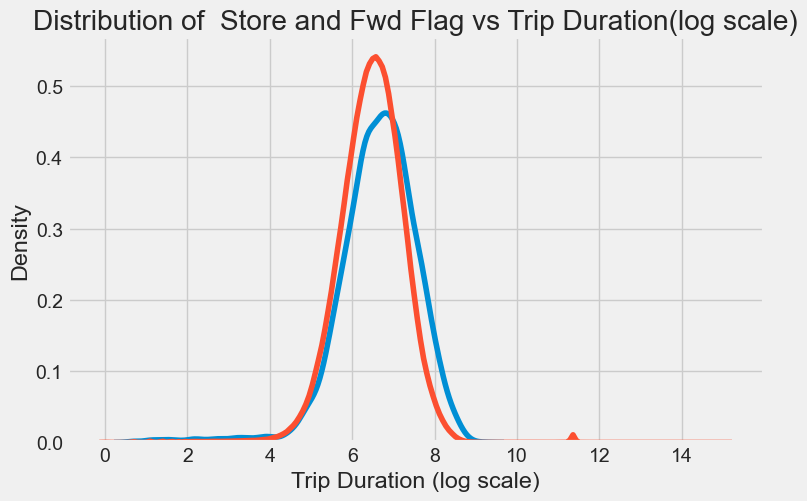

In [66]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y','trip_duration'].values),label= 'Store and Fwd =Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N','trip_duration'].values),label= 'Store and Fwd =No')
   
plt.title("Distribution of  Store and Fwd Flag vs Trip Duration(log scale)")
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')

(-74.03, -73.75)

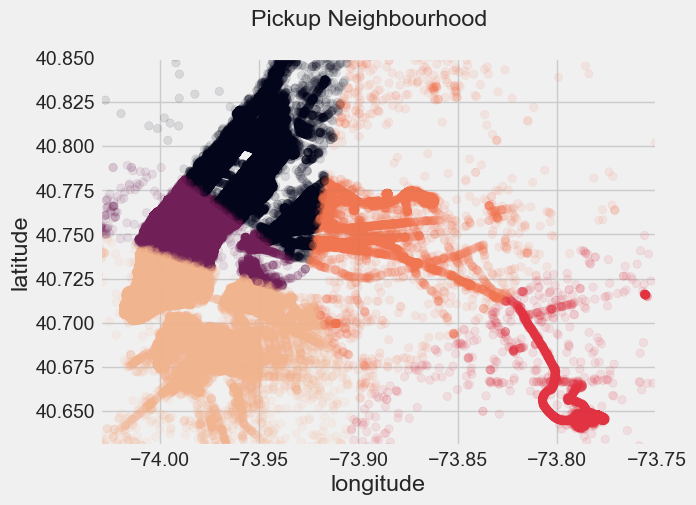

In [67]:
# k-means clustering에 따른 분류
# cluster 수 - 8
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(coords)
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
              c=train['pickup_neighbourhood'], label='train', alpha=0.1)

fig.suptitle('Pickup Neighbourhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)



## 이후로 코드가 실행되지 않아 필사만 진행

In [ ]:
plt.figure(figsize = (8,5))
sns.countplot(train['pickup_neighbourhood']).set_title("Distribution of Number of Pickups across Neighbourhoods")

In [ ]:
avg_duration_neighbourhood = train.groupby(['pickup_neighbourhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration':'avg_trip_duration'})
plt.figure(figsize = (8,5))
sns.barplot(x = 'pickup_neighbourhood', y = 'avg_trip_duration', data = avg_duration_neighbourhood).set_title("Avg Trip Duration vs Neighbourhood")

In [ ]:
train['avg_speed_kph'] = train['trip_distance']/train['trip_duration_in_hour']
plt.figure(figsize = (8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title("Distribution of Average Speed (in kph)")

In [ ]:
print("Average speed is",np.mean(train['avg_speed_kph']),"kph") #The average speed is 14 kmph

In [ ]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize = (8,5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_speed_kph', data = avg_speed_per_day, order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title("Avg Speed (kph) vs Pickup Days of Week")

In [ ]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'],format = '%Y-%m-%d %H:%M:%S')
test['dropoff_datetime'] = pd.to_datetime(test['dropoff_datetime'],format = '%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].apply(lambda x: x.day)
test['pickup_hour'] = test['pickup_datetime'].apply(lambda x: x.hour)
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date'] = test['dropoff_datetime'].dt.date
#test['dropoff_day'] = test['dropoff_datetime'].apply(lambda x: x.day)
#test['dropoff_hour'] = test['dropoff_datetime'].apply(lambda x: x.hour)
#test['dropoff_day_of_week'] = test['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
test['pickup_latitude_round3'] = test['pickup_latitude'].apply(lambda x: round(x,3))
test['pickup_longitude_round3'] = test['pickup_longitude'].apply(lambda x: round(x,3))
test['dropoff_latitude_round3'] = test['dropoff_latitude'].apply(lambda x: round(x,3))
test['dropoff_longitude_round3'] = test['dropoff_longitude'].apply(lambda x: round(x,3))
test['trip_distance'] = test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour'] = test['trip_duration'].apply(lambda x:x/3600)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'], row['pickup_longitude_round3'], row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [ ]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)


In [ ]:
training['log_trip_duration']=training['trip_duration'].apply(lambda x: np.log(x))
training.drop(['trip_duration'],axis=1,inplace=True)

In [ ]:
print("Training Data Shape ", training.shape)
print("Testing Data Shape ", testing.shape)

In [ ]:
# 요일정보를 수치화
def encodeDays(day_of_week):
    day_dict = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
    return day_dict[day_of_week]

In [ ]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x:encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x:encodeDays(x))


In [ ]:
training.to_csv("input_training.csv",index=False)
testing.to_csv("input_testing.csv",index=False)
del training
del testing
del train
del test

In [ ]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
                

def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
   
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [ ]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [ ]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',split=0.25,imputation=True):
    labels=np.array(train[target])
    training=train.drop(target, axis = 1)
    training = np.array(training)
    testing=np.array(test)
    if imputation==True:
        imputer=Imputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

In [ ]:
train_features,validation_features,train_labels,validation_labels,testing=GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

In [ ]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)

In [ ]:
valid_pred=lm.predict(validation_features)

In [ ]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

In [ ]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_linear_regression_baseline.csv",index=False) #0.64221 on Leader board
del submit

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [ ]:
rf.fit(train_features,train_labels)

In [ ]:
valid_pred_rf=rf.predict(validation_features)
rmse=mean_squared_error(validation_labels,valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)


In [ ]:
test_pred=rf.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
submit['trip_duration']=np.exp(test_pred)
submit.to_csv("submission_random_forest_baseline.csv",index=False)